# Commute time analysis

I moved house and now have to drive to and from work.  Before moving, I had been told that the traffic is highly variable so I have been recording the start and stop times whenever I remember.  This notebook is a brief analysis of the commute times.

Questions:

1. Is the morning rush hour longer than other commutes?
2. Is the morning rush hour drive longer on particular days?
3. Has the rush hour commute changed over the months?
4. Does leaving early help me get home early?
5. Google maps can be used to predict the journey duration.  Is this prediction accurate?

## Importing and formatting the data

First, let's have a look at the raw CSV file.

In [1]:
with open('commutes.csv') as f:
    for line_num, line in enumerate(f):
        if line_num > 4:
            break
        print(line.strip())

date,prediction,start,stop,duration,day
14/08/2015,,08:02:00,08:22:00,20,Fri
25/08/2015,,18:16:00,18:27:00,11,Tue
26/08/2015,,08:26:00,08:46:00,20,Wed
26/08/2015,,18:28:00,18:46:00,18,Wed


The `date` column is the date of the commute.

The first few lines of the `prediction` column are empty, but later rows contain the duration in minutes as predicted by Google Maps.

The `start` and `stop` are the times of the beginning and end of the commute.  The `duration` is the actual commute duration in minutes, and the `day` is the first 3 letters of the day of the week.

Let's import the CSV data into the data analysis package pandas.

In [2]:
import pandas as pd

# Read the CSV to a pandas DataFrame, combining column 2 (start time)
# with column 0 (date), and column 3 (end time) with column 0
commutes = pd.read_csv('commutes.csv', parse_dates=[[2, 0], [3, 0]], 
                       dayfirst=True)
commutes.head()

,start_date,stop_date,prediction,duration,day
0,2015-08-14 08:02:00,2015-08-14 08:22:00,NaN,20,Fri
1,2015-08-25 18:16:00,2015-08-25 18:27:00,NaN,11,Tue
2,2015-08-26 08:26:00,2015-08-26 08:46:00,NaN,20,Wed
3,2015-08-26 18:28:00,2015-08-26 18:46:00,NaN,18,Wed
4,2015-08-28 08:37:00,2015-08-28 08:52:00,NaN,15,Fri


In [3]:
# Check data types.  Note that 'object' actually means 'string'
commutes.dtypes

start_date    datetime64[ns]
stop_date     datetime64[ns]
prediction           float64
duration               int64
day                   object
dtype: object

Python has a `datetime` type, but not a `time` type alone.  Therefore, we need a way of representing the time of day independently of the date.  We can use a floating point number of hours so 08:30 in the morning is 8.5 hours.  Let us define a function to convert a string of the format `hh:mm:ss` to a floating point number of hours.

In [4]:
def to_hours(dt):
    """Return floating point number of hours through the day in `datetime` dt."""
    return dt.hour + dt.minute / 60 + dt.second / 3600


# Unit test the to_hours() function
import datetime
dt = datetime.datetime(2010, 4, 23)  # Dummy date for testing
assert to_hours(dt) == 0
assert to_hours(dt.replace(hour=1)) == 1
assert to_hours(dt.replace(hour=2, minute=30)) == 2.5
assert to_hours(dt.replace(minute=15)) == 0.25
assert to_hours(dt.replace(second=30)) == 30 / 3600

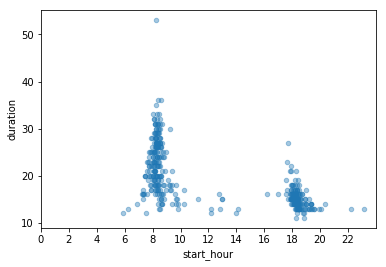

In [5]:
# Convert start and stop times to hours
commutes['start_hour'] = commutes['start_date'].map(to_hours)
commutes['stop_hour'] = commutes['stop_date'].map(to_hours)

# Tell the plotting library to plot inline
%matplotlib inline
import numpy as np

# Plot the duration versus start time
# ax is the axes object for the chart
ax = commutes.plot.scatter('start_hour', 'duration', alpha=0.4)

# Set the x axis (start_hour) range from 0 to 24 hours, with a
# tick every 2 hours
hour_ticks = np.arange(0, 24, 2)
ax.xaxis.set_ticks(hour_ticks);

The duration axis above is in minutes.

##  Is the morning rush hour longer than other commutes?

Let us see if the morning rush hour takes longer than other times of the day.  Let us define the morning rush hour as 07:00 to 09:30.

We need to categorise the journeys as starting in rush hour or not.

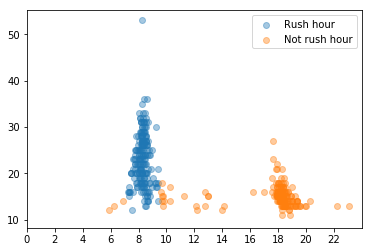

In [6]:
# Create a mask to select the rush hour rows
rush_hour_mask = (commutes['start_hour'] >= 7) & (commutes['start_hour'] < 9.5)

# Select just the rush hour rows
rush_hour = commutes[rush_hour_mask]

# Select just the NOT rush hour rows
not_rush_hour = commutes[~rush_hour_mask]

# Plot the scatter plot again, but with different colours for rush hour or not
import matplotlib.pyplot as plt

# fig is short for `figure` and ax is short for `axes`
fig, ax = plt.subplots()
ax.scatter(rush_hour['start_hour'], rush_hour['duration'], 
           label='Rush hour', alpha=0.4)

ax.scatter(not_rush_hour['start_hour'], not_rush_hour['duration'], 
           label='Not rush hour', alpha=0.4)

ax.xaxis.set_ticks(hour_ticks)
ax.legend();

We can see above that our selections have correctly identified the rush hour commutes.

It might be easier to see the difference between commute durations for rush hour or not using a histogram.

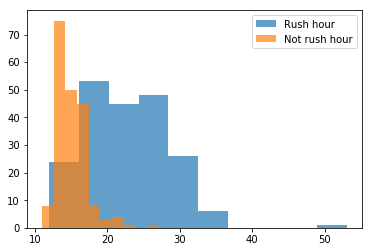

In [7]:
fig, ax = plt.subplots()
ax.hist(rush_hour['duration'], label='Rush hour', alpha=0.7)
ax.hist(not_rush_hour['duration'], label='Not rush hour', alpha=0.7)
ax.legend();

The histogram is not very helpful from a statistical point of view: we cannot see where the median or other statistical values are.  It may be better to create a box plot.  We could create a box plot by creating a figure and axes, then add a box plot for rush hour and not rush hour.

However, a faster way might be to add a column to the `commutes` DataFrame which says whether the commute is rush hour or not, then box plot the `commutes` DataFrame directly.

In [8]:
# Use the existing `rush_hour_mask` to populate the new `rush_hour` column
# with whether the commute is rush hour or not
commutes['rush_hour'] = np.where(rush_hour_mask, 'rush hour', 'not rush hour')
commutes.head()

,start_date,stop_date,prediction,duration,day,start_hour,stop_hour,rush_hour
0,2015-08-14 08:02:00,2015-08-14 08:22:00,NaN,20,Fri,8.033333,8.366667,rush hour
1,2015-08-25 18:16:00,2015-08-25 18:27:00,NaN,11,Tue,18.266667,18.450000,not rush hour
2,2015-08-26 08:26:00,2015-08-26 08:46:00,NaN,20,Wed,8.433333,8.766667,rush hour
3,2015-08-26 18:28:00,2015-08-26 18:46:00,NaN,18,Wed,18.466667,18.766667,not rush hour
4,2015-08-28 08:37:00,2015-08-28 08:52:00,NaN,15,Fri,8.616667,8.866667,rush hour


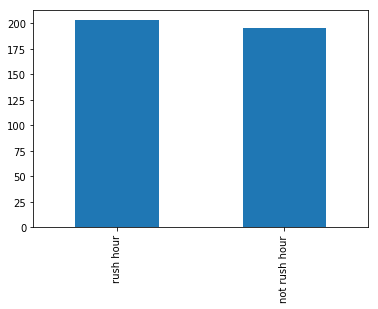

In [9]:
# Count the number of commutes in each group
commutes['rush_hour'].value_counts().plot.bar();

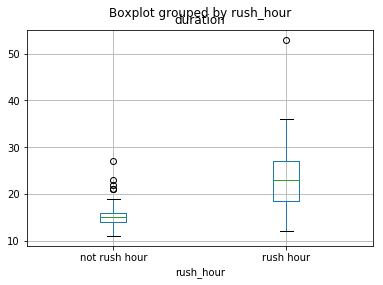

In [10]:
# Boxplot the `duration`, grouped by `rush_hour`
commutes.boxplot(column='duration', by='rush_hour');

If you are not familiar with reading box plots, this image shows what the symbols mean:

![Box plot explanation](http://www.bom.gov.au/water/ssf/faq/boxplot.png "Box plot explanation")

### Hypothesis test: are rush hour commutes longer than others?

The journeys are independent so we shall use the [independent 2 sample t-test](http://en.wikipedia.org/wiki/T-test#Independent_two-sample_t-test).  The null hypothesis is that there is no difference between journey duration in rush hour or not.

If the P-value is below a threshold we set, let us say 5% (or 0.05), then we have to reject the null hypthesis and conclude that there is a difference between the journey duration means.

In [11]:
# Import the t-test function
from scipy.stats import ttest_ind

ttest_ind(rush_hour['duration'], not_rush_hour['duration'])

Ttest_indResult(statistic=18.573015835352599, pvalue=7.8024306566554162e-56)

The P-value is less than 0.05, so we reject the null hypothesis and conclude that rush hour is indeed different to outside rush hour.  We can calculate the means too.

In [12]:
print('Rush hour mean duration {:.2f} minutes'.format(rush_hour['duration'].mean()))
print('Non rush hour mean duration {:.2f} minutes'.format(not_rush_hour['duration'].mean()))

Rush hour mean duration 23.02 minutes
Non rush hour mean duration 15.02 minutes


Is there a trend of journey duration within rush hour?

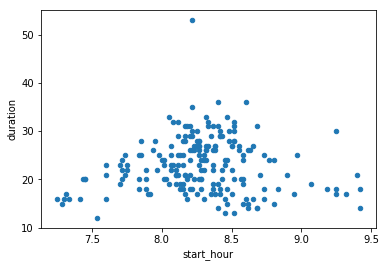

In [13]:
rush_hour.plot.scatter('start_hour', 'duration');

There does not seem to be a particular trend of duration against start time.  It just seems that the worst time to start is between 08:00 and 08:45.

## Is the morning rush hour drive longer on particular days?

First, we should check how many data points (commutes) we have for each day of the week.

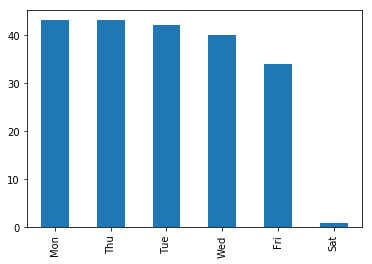

In [14]:
# Count the number of rush hour commutes in each day
rush_hour['day'].value_counts().plot.bar();

We only have 1 on Saturday, and none on Sunday, so should bear these in mind when assessing the median commute durations next...

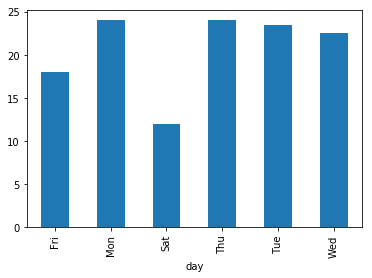

In [15]:
# Group the rush hour commutes by day of the week, then select the `duration` column,
# calculate the median for each day, and plot a bar chart
rush_hour.groupby('day')['duration'].median().plot.bar();

The bar chart of median commute duration shows us that Saturday is faster, then Friday, with the other days being roughly the same.  However, the median is only one measure, so we should create a box plot (below) too.  The box plot makes the bar chart obsolete, but we can leave it here as example code.

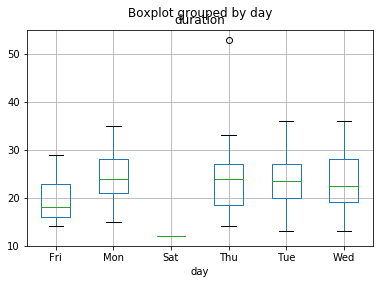

In [16]:
# Box plot the rush hour duration by day
rush_hour.boxplot(column='duration', by='day');

Saturday has the shortest commute, which we might expect.  The Friday commute seems a little faster than other days.

## Has the rush hour commute changed over the months?

We should group the start date into months, then plot the median duration.

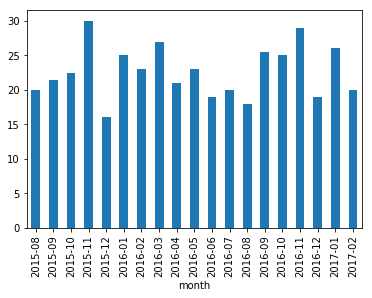

In [17]:
# Copy the rush hour data so that we can set the index to `start_date` 
# for grouping by month
rush_hour_monthly = rush_hour.copy().set_index('start_date')

# Create a new column `month` containing a string of the month (YYYY-MM)
rush_hour_monthly['month'] = rush_hour_monthly.index.to_period('M')

# Plot a bar chart of median durations
rush_hour_monthly.groupby('month')['duration'].median().plot.bar();

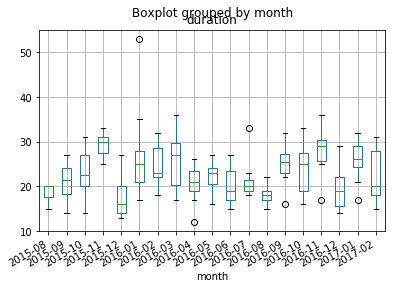

In [18]:
# Create a boxplot of the durations by month
ax = rush_hour_monthly.boxplot(column='duration', by='month')

# Format the x axis for dates
ax.get_figure().autofmt_xdate();

The bar chart is much clearer than the box plot for comparing median durations during rush hour by month.

It seems that November has long rush hour drives each year.  December and August are both on the lower end.  December could be explained by many workers using up their annual leave, and August is likely to have low rush hour journey durations due to school holidays.

## Does leaving early help me get home early?

Let us filter the journeys into those around home time (17:00 to 19:00).

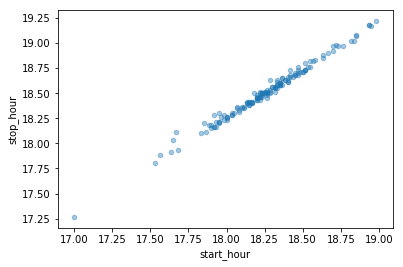

In [19]:
evening_mask = (commutes['start_hour'] >= 17) & (commutes['start_hour'] < 19)

# Select the rows in evening_mask
evening = commutes[evening_mask]
evening.plot.scatter('start_hour', 'stop_hour', alpha=0.4);

On a couple of occasions, leaving between 17:30 and 17:45 did not get me home much sooner than leaving at about 17:50, but in general it is worth leaving as soon as ready.

## Google maps can be used to predict the journey duration.  Is this prediction accurate?

We should use a technique like regression.  There are a number of ways that we can visualise or calculate regression in Python:

1. Plotting using the `seaborn` package.
2. Calculating and plotting using the `numpy.polyfit` function.
3. Calculating using the `statsmodels` package.

We shall try each of them in turn.

### Regression plot using the seaborn package

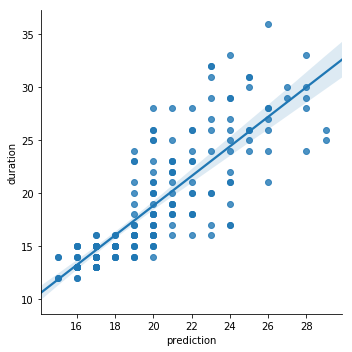

In [20]:
import seaborn as sns

# Reset plot styles
sns.reset_orig()

# Create a linear model plot
sns.lmplot('prediction', 'duration', commutes);

The regression line is plotted in dark blue, and the 95% confidence interval for the regression line is plotted in tranlucent blue.  However, we do not know the $R^2$ value for correlation, nor the equation of the line.

We shall try the numpy polyfit function.

### Regression equation using the polyfit function

In [21]:
# Create a copy of the commutes and remove commutes with no prediction
# because numpy.polyfit raises an error if there are NaNs (NaN = not a number)
predictions = commutes[['prediction', 'duration']].copy().dropna()
predictions.head()

,prediction,duration
184,29.0,26
185,20.0,19
189,24.0,21
190,19.0,19
191,24.0,19


Gradient: 1.401; intercept: -9.215


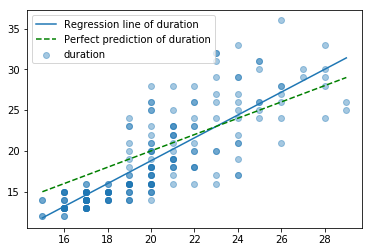

In [22]:
def plot_regression(x, y, gradient, intercept):
    """Plot the scatter of x and y data and the regression line."""
    # Create a new figure and axes
    fig, ax = plt.subplots()
    
    # Plot the scatter of data points
    ax.scatter(x, y, alpha=0.4)
    
    # Create an array of start values from the minimum to maximum to create the regression line
    X = np.linspace(x.min(), x.max())

    # Plot the regression line
    ax.plot(X, gradient * X + intercept, label='Regression line of duration')

    # Plot the line of perfect prediction
    ax.plot(X, X, 'g--', label='Perfect prediction of duration')
    ax.legend()
    return ax


x = predictions['prediction']
y = predictions['duration']

# Calcuate the gradient and intercept of the regression line from a least-squares fit
# of a 1-order polynomial
gradient, intercept = np.polyfit(x, y, 1)

# Plot the regression line
plot_regression(x, y, gradient, intercept)

# Print the regression line parameters
print('Gradient: {:.3f}; intercept: {:.3f}'.format(gradient, intercept))

If the prediction was very good, we would see a gradient of 1 and an intercept of 0 minutes.  We actually see that the prediction overestimates commutes under about 23 minutes, but underestimates commutes over about 23 minutes.

For completeness, we shall use the statsmodels package to calculate the regression.

### Regression using the statsmodels package

In [23]:
import statsmodels.api as sm

fit = sm.OLS(y, sm.add_constant(x)).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               duration   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     441.4
Date:                Sun, 26 Feb 2017   Prob (F-statistic):           2.54e-53
Time:                        20:25:38   Log-Likelihood:                -538.14
No. Observations:                 210   AIC:                             1080.
Df Residuals:                     208   BIC:                             1087.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -9.2150      1.355     -6.802      0.000       -11.886    -6.544
prediction     1.4006      0.067     21.009      0.000         1.269     1.532
==============================================================================
Omnibus:                       20.395   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.870
Skew:                           0.688   Prob(JB):                     3.98e-06
Kurtosis:                       3.974   Cond. No.                         127.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

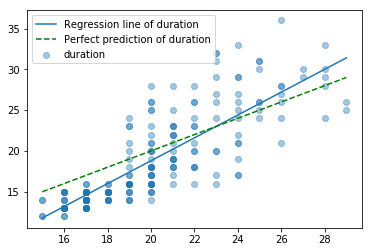

In [24]:
# Plot the scatter of data points
plot_regression(x, y, fit.params['prediction'], fit.params['const']);

## Summary

We can now answer the original questions:

1. Is the morning rush hour longer than other commutes?
 - Yes.  Rush hour has a mean of 23 minutes compared to 15 minutes outside rush hour.
2. Is the morning rush hour drive longer on particular days?
 - Yes. Saturday is the shortest commute, then Friday.  The other days are longer than those and similar to one another.
3. Has the rush hour commute changed over the months?
 - November has long rush hour drives each year.  December and August are both on the lower end.
4. Does leaving early help me get home early?
 - Yes.
5. Google maps can be used to predict the journey duration.  Is this prediction accurate?
 - The prediction is not bad. It overestimates commutes under about 23 minutes, but underestimates commutes over about 23 minutes.
 
## Future work

Further work could include:

1. Calculate the confidence interval on predictions from Google Maps.
2. Calculate the effect of road works which started on 2017-02-20, and which should only affect the rush hour commute.

## Comparison with Excel

We often have the choice of whether to conduct analyses like this in Microsoft Excel or Python.  The experience of writing the above analysis has suggested that we should use Excel when:

- The data set is relatively short (less than a few thousand rows, for speed reasons); and
- The analysis is a 'one-off'.  That is, it does not need to be repeated when new data are available; and
- The data are contained in only one or a very small number of files (because manual manipulation of many files is tedious and error-prone); and
- No advanced data manipulations are required, such as resampling by date.

We should use Python when one or more of the above are not true.

## Appendix

Print the date and software version numbers.

In [25]:
import sys
import matplotlib as mpl
import statsmodels

print('Last modified',datetime.date.today())

print('Python', sys.version)

for package in (pd, np, mpl, statsmodels):
    print(package.__name__, package.__version__)

Last modified 2017-02-26
Python 3.5.2 |Anaconda 4.3.0 (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]
pandas 0.19.2
numpy 1.11.3
matplotlib 2.0.0
statsmodels 0.6.1


## Licence

This document is public domain.